In [1]:
#from __future__ import absolute_import, division, print_function

import os
import sys
import skimage.io
import numpy as np
import caffe
import json
import timeit
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
sys.path.append('../')
sys.path.append('../lang_seg_model')

from lang_seg_model import lang_seg_model as segmodel
from util import processing_tools, im_processing, text_processing, eval_tools
import demo_config

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

# Load config
config = demo_config.Config()

# Load the model
with open('./demo.prototxt', 'w') as f:
    f.write(str(segmodel.generate_model('val', config)))

caffe.set_device(config.gpu_id)
caffe.set_mode_gpu()

net = caffe.Net('./demo.prototxt', config.pretrained_model, caffe.TEST)

# Load vocabulary
vocab_dict = text_processing.load_vocab_dict_from_file(config.vocab_file)

In [5]:
# input image and query text
im_file = './demo_data/38100.jpg'
query = 'sky above the bridge'

# Run on the input image and query text
text_seq_val = np.zeros((config.T, config.N), dtype=np.float32)
imcrop_val = np.zeros((config.N, config.input_H, config.input_W, 3), dtype=np.float32)

# Preprocess image and text
im = skimage.io.imread(im_file)
processed_im = skimage.img_as_ubyte(im_processing.resize_and_pad(im, config.input_H, config.input_W))
if processed_im.ndim == 2:
    processed_im = np.tile(processed_im[:, :, np.newaxis], (1, 1, 3))
imcrop_val[0, :] = processed_im.astype(np.float32) - segmodel.channel_mean
imcrop_val = imcrop_val.transpose((0, 3, 1, 2))
imcrop_val = imcrop_val[:, ::-1, :, :]

spatial_val = processing_tools.generate_spatial_batch(config.N, config.featmap_H, config.featmap_W)
spatial_val = spatial_val.transpose((0, 3, 1, 2))

text_seq_val[:, 0] = text_processing.preprocess_sentence(query, vocab_dict, config.T)
cont_val = text_processing.create_cont(text_seq_val)

dummy_label = np.zeros((config.N, 1, config.input_H, config.input_W), dtype=np.float32)

# Forward pass to get response map
net.blobs['language'].data[...] = text_seq_val
net.blobs['cont'].data[...] = cont_val
net.blobs['image'].data[...] = imcrop_val
net.blobs['spatial'].data[...] = spatial_val
net.blobs['label'].data[...] = dummy_label

net.forward()

upscores = net.blobs['upscores'].data[...].copy()
upscores = np.squeeze(upscores)

# Final prediction
#prediction = im_processing.resize_and_crop(upscores>0, *im.shape[:2]).astype(np.bool)
upscores = sigmoid(upscores)
upscores = upscores*255
prediction = im_processing.resize_and_crop(upscores.astype(np.int32), *im.shape[:2])

# Binary mask
score_thresh = np.amax(upscores) * 0.5
prediction_binary = im_processing.resize_and_crop(upscores>score_thresh, *im.shape[:2]).astype(np.bool)
mask_file = './demo_data/38100_mask.jpg'
plt.imsave(mask_file, np.array(prediction_binary), cmap=cm.gray)

# Bbox prediction
bbox_threshold = [20, 100, 110] # parameters for the bbox generator
paraThreshold = str(bbox_threshold[0])+' '+str(bbox_threshold[1])+' '+str(bbox_threshold[2])+' '
bbox_file = './demo_data/38100_box.txt'
os.system("bboxgenerator/./dt_box "+mask_file+' '+paraThreshold+' '+bbox_file)

predction_bbox = np.copy(im)
bbbox = eval_tools.compute_bbox_max(bbox_file)
cv2.rectangle(predction_bbox, (bbbox[0], bbbox[1]), (bbbox[2], bbbox[3]), (0, 255, 0), 3)


/home/zhenyang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


query text = 'sky above the bridge'


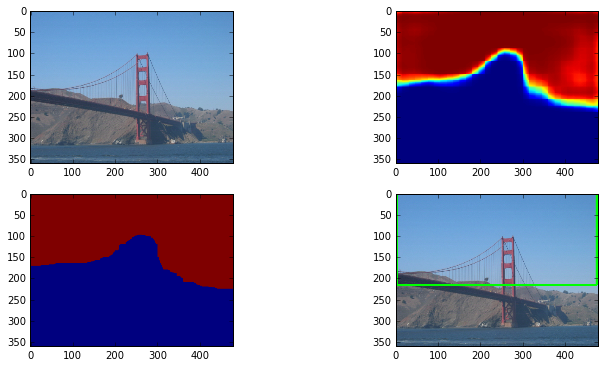

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(im)
plt.subplot(2, 2, 2)
plt.imshow(prediction)
plt.subplot(2, 2, 3)
plt.imshow(prediction_binary)
plt.subplot(2, 2, 4)
plt.imshow(predction_bbox)

print("query text = '%s'" % query)